# Assignment 1

**Deadline**: 17/09/2024, 17.00

**Names and student numbers:**

1. Albin Lindqvist (13986236)
2. ...
3. ...

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:

1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.

## Instructions for completing and submitting the assignment

Please pay attention to the following instructions:

1. Please follow carefully the steps outlined in the assignment. If you cannot solve an exercise and this hinders continuing with subsequent exercises, try to find a way to work around it and give a clear explanation for the solution you have chosen.
2. Submit your work in the form of a Jupyter notebook via Canvas, before the deadline. Your notebook should not give errors when executed with `Run All`.
3. You are allowed to work on the assignment in groups of 2 or 3 students and to submit together. Before you submit, you and your team members have to register as an **Assignments group** on Canvas. Only a single member of each group has to submit the notebook. Please do **NOT** submit the same notebook multiple times!
4. Please write your names also inside this markdown cell, under **Names and student numbers**.


## Part 0: importing the relevant libraries


**Exercise 1:** import all the libraries you are using in this notebook.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import sklearn
import sklearn.utils
import sklearn.datasets
from sklearn.metrics import root_mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

np.random.seed(42)
rng = np.random.RandomState(42)

## Part 1: plagiarism detection

In this part we want to compute a metric that measures the distance between two text documents. This allows us to find out whether two documents are similar. This is important for instance if you are Google, that tries to find how well a website matches to your search query. This distance will also allow us to detect duplicates (like Wikipedia mirrors) and cases of plagiarism (you are warned).

The idea is to define distance in terms of shared words. We will think of a document D as a dictionary such that D[W] is the number of occurrences of word W. In other terms, we only keep track of how often each word occurs in the document. For example the documents

    "The dog ate the homework."

and

    "The cat ate the homework."

will be thought of as two dictionaries

    {"the": 2, "dog": 1, "ate": 1, "homework": 1}
    {"the": 2, "cat": 1, "ate": 1, "homework": 1}

Note that we make no distinction between upper and lower case words.

To make the two documents comparable, we want to ensure that both dictionaries have the same keys, so

    d1 = {"the": 2, "dog": 1, "cat": 0, "ate": 1, "homework": 1}
    d2 = {"the": 2, "dog": 0, "cat": 1, "ate": 1, "homework": 1}

An appropriate distance measure between two documents we will use is the angle between these documents. From linear algebra, we know that we can compute the angle between two vectors $\vec{x}$ and $\vec{y}$ with
$$\angle(\vec{x}, \vec{y}) = \cos^{-1}\left(\frac{\langle \vec{x}, \vec{y}\rangle}{\|\vec{x}\| \|\vec{y}\|}\right).$$
If we extract only the word frequencies of the two documents as lists and consider them as vectors, we can compute their angle:

    x = [2, 1, 0, 1, 1]
    y = [2, 0, 1, 1, 1]
    angle = arccos(6/7)

If the angle is zero, this means the two documents are identical (in terms of word counts), whereas an angle of 90 degrees means there are no common words.


**Exercise 2:** in the cell below, create a function `compute_angle` that computes the angle between two texts. The input arguments are two strings of text and the function should return the angle (in radians). As a courtesy, we already defined the function and wrote a docstring for the function.

Make sure your code has enough comments, so that a third reader can easily read and understand your code. Also make sure that interpunction (`.,!?:;`) is removed from the two texts, before computing the angle between them.

In order to test your code, run the second cell below without making any changes to it.

Hint: it is possible to write all your operations inside a single function `compute_angle`, but your code probably becomes better readable if you define auxiliary functions for sub-operations. Place these functions before the `compute_angle` function, so that you can call them in `compute_angle` when needed.


In [6]:
def remove_punctuation(text):
    return re.sub(r"[.,!?:;]", "", text)


def compute_angle(text1, text2):
    """
    Return the angle (in radians) between two texts.

    Parameters
    ----------
        text1 (str): First input text.
        text2 (str): Second input text.

    Returns
    -------
        angle (float): The angle in radians between the value vectors (the word counts).

    Example
    -------
        dictionary1 = {'the': 2, 'dog': 1, 'ate': 1, 'homework': 1}
        dictionary2 = {'the': 2, 'ate': 1, 'homework': 1, 'cat': 1}
        dictionary_angle(dictionary1, dictionary2)
            0.541099525957146
    """
    # Clean the texts and split them into words
    clean_text1 = remove_punctuation(text1).lower().split()
    clean_text2 = remove_punctuation(text2).lower().split()

    # Create a set of all words, and two zero initialized dictionaries (documents)
    all_words = set(clean_text1).union(set(clean_text2))
    d1 = dict.fromkeys(all_words, 0)
    d2 = dict.fromkeys(all_words, 0)

    # Count the words in the documents
    for word in clean_text1:
        d1[word] += 1

    # Count the words in the documents
    for word in clean_text2:
        d2[word] += 1

    # Convert the dictionaries to vectors
    v1 = np.array(list(d1.values()))
    v2 = np.array(list(d2.values()))

    # Compute the angle between the vectors
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

In [7]:
#### DO NOT CHANGE THE CODE IN THIS CELL ####
text1 = "The dog ate the homework."
text2 = "The cat ate the homework."

Obama = "And Barack and I were raised with so many of the same values: \
         that you work hard for what you want in life; that your word \
         is your bond and you do what you say you're going to do; that \
         you treat people with dignity and respect, even if you don't know \
         them, and even if you don't agree with them. And Barack and I set \
         out to build lives guided by these values, and to pass them on to \
         the next generation. Because we want our children and all children \
         in this nation to know that the only limit to the height of your \
         achievements is the reach of your dreams and your willingness to \
         work for them."

Trump = "From a young age, my parents impressed on me the values that you \
         work hard for what you want in life, that your word is your bond and \
         you do what you say and keep your promise, that you treat people \
         with respect. They taught and showed me values and morals in their \
         daily lives. That is a lesson that I continue to pass along to our \
         son. And we need to pass those lessons on to the many generations to \
         follow. Because we want our children in this nation to know that the \
         only limit to your achievements is the strength of your dreams and \
         your willingness to work for them."

print(compute_angle(text1, text2))
print(compute_angle(Trump, Obama))

0.541099525957146
0.578729546285134


## Part 2: wrangling and analyzing Twitter sentiment data

This part of the assignment is about wrangling and analyzing Twitter sentiment data for six airline companies:

| **Name Airline**   | **@username**  |
| :----------------- | :------------- |
| American Airlines  | @AmericanAir   |
| JetBlue Airways    | @JetBlue       |
| Southwest Airlines | @SouthwestAir  |
| United Airlines    | @united        |
| US Airways         | @USAirways     |
| Virgin America     | @VirginAmerica |

The dataset `DSM_assignment1_twitter_data.csv` consists of more than 14.000 tweets sent on 9 consecutive days in February 2015, all addressing one (or more) of the aforementioned airlines via the @username syntax. The text of the tweets can be found in the `text` column of the dataset. Another relevant column is called `tweet_created`, giving the time and day at which the tweet was sent.

Furthermore, a machine learning algorithm has analyzed the content of the tweets and categorized the sentiment as positive, neutral or negative. This data can be found in `DSM_assignment1_sentiment_data.csv`. The sentiment can be found in the `airline_sentiment` column. The machine learning algorithm also estimates the probability that it identified the correct sentiment, which is given in the `airline_sentiment:confidence` column.

The column `_unit_id` can be found in both datasets and can be used as a key to match the tweets with the sentiment data.

(Note: US Airways was integrated into American Airlines in October 2015. Since our dataset is from February 2015, we will consider them as separate airlines.)


**Exercise 3:** import the datasets `DSM_assignment1_twitter_data.csv` and `DSM_assignment1_sentiment_data.csv` and turn them into two DataFrames, called respectively `df_twitter` and `df_sentiment`.


In [8]:
df_twitter = pd.read_csv("DSM_assignment1_twitter_data.csv")
df_sentiment = pd.read_csv("DSM_assignment1_sentiment_data.csv")

**Exercise 4:** during the creation of both datasets some lines/rows were duplicated. Remove the duplicates from both DataFrames.


In [9]:
df_twitter.drop_duplicates(inplace=True)
df_sentiment.drop_duplicates(inplace=True)

**Exercise 5:** the machine learning algorithm is not always able to extract a sentiment from the tweet. This is reflected in a missing `airline_sentiment` value in `df_sentiment`. Remove the lines with a missing airline sentiment from the DataFrame and call the new DataFrame `df_sentiment_notnull`. Report the number of discarded lines by printing it.


In [10]:
df_sentiment_notnull = df_sentiment.dropna(subset=["airline_sentiment"])
print(f"Rows removed: {len(df_sentiment) - len(df_sentiment_notnull)}")

Rows removed: 36


**Exercise 6:** use the column `_unit_id` to merge the DataFrames `df_twitter` and `df_sentiment_notnull`. Call the resulting DataFrame `df`. Make sure that `df` contains only the entries that have both Twitter and sentiment data.

Report the total number of tweets in the merged dataset, as well as the number of removed tweets from the Twitter dataset and the number of removed tweets from the sentiment dataset.


In [11]:
df = pd.merge(df_twitter, df_sentiment_notnull, how="inner")
print(
    f"The total number of tweets in the merged data set is {len(df)}, {len(df_twitter) - len(df)}"
    f" rows were removed from df_twitter and {len(df_sentiment_notnull) - len(df)} rows were"
    f" removed from df_sentiment_notnull"
)

The total number of tweets in the merged data set is 14484, 46 rows were removed from df_twitter and 109 rows were removed from df_sentiment_notnull


**Exercise 7:** crucially, what is still missing in the data is a column with the airline company that is being addressed in the tweet. This is done using Twitter's @username syntax, which is called a _mention_. For example, if the text of a tweet contains the (sub)string `@AmericanAir`, we may assume the tweet is addressed to American Airlines. We have to extract this information from the text of the tweet. This can be done using regular expressions, for instance (see [this](https://regexone.com) website for basic instructions). However, we have to be careful, as some tweets contain multiple mentions.

This exercise contains three parts, corresponding to the three cells below:

- in the first cell, create a new column called `mentions` in the `df`. The values of this column must be **lists** containing **all** the @username occurences (string type) in the text of a tweet. You can use regular expressions for extracting the @username occurences.
- the second cell is a markdown cell, where you have to give an answer in plain text. In this cell, please explain carefully your approach for extracting the mentions from the tweet and the choices you have made. In particular, explain how you managed to extract **all** @username occurrences.
- in the third cell, print the total number of mentions you have extracted from all tweets together, as well as the average number of mentions per tweet. Furthermore, draw a random sample of 15 entries of the `mentions` column and print the sample (as a Series).


In [12]:
df["mentions"] = df["text"].str.findall(r"@[\w\d]+")

#### ANSWER IN PLAIN TEXT:

We use regular expression and the function findall to get all matching occurances. The regex we are using `r"@[\w\d]+"` finds all occurances where a word begins with an @ and is followed by one or more (`+`) letters (`\w`) or numbers (`\d`). We are using the string function provided by `pandas.DataFrame.str` instead of `pandas.DataFrame.apply` with the `re.findall` because in general the provided functions are more efficent.


In [13]:
print(f"Total number of mentions in all tweets {df['mentions'].str.len().sum()}")
print(
    f"That gives the average number of mentions per tweet {df['mentions'].str.len().mean():.4f}"
)
df["mentions"].sample(15)

Total number of mentions in all tweets 16336
That gives the average number of mentions per tweet 1.1279


14442                     [@SouthwestAir]
9285                      [@SouthwestAir]
2366                         [@USAirways]
3325                         [@USAirways]
169                      [@VirginAmerica]
2034        [@SouthwestAir, @BWI_Airport]
5257                            [@united]
1944     [@SouthwestAir, @Imaginedragons]
4436                           [@JetBlue]
8823                         [@USAirways]
8348                            [@united]
6013                         [@USAirways]
5762                           [@JetBlue]
5787                         [@USAirways]
3855                      [@SouthwestAir]
Name: mentions, dtype: object

## Part 3: visualizing the California housing market


**Exercise 8:** use the California housing dataset of `sklearn` to create a figure with the following properties:

- the figure shows the locations (in terms of longitude and latitude) of the houses in the dataset.
- the coloring of each house in the plot should be based on its associated median house value, which is a continuous scale.
- the figure should also contain a colorbar, indicating the scale of the coloring scheme.
- the figure, the horizontal axis, the vertical axis and the colorbar should be labeled appropriately.


Text(0.5, 1.0, 'California District Median House Value Plot')

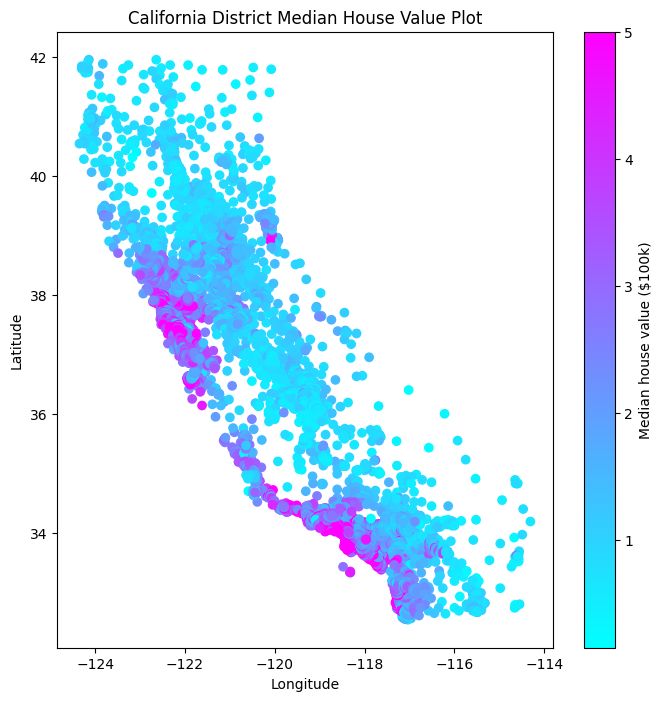

In [14]:
california_data: sklearn.utils.Bunch = sklearn.datasets.fetch_california_housing()  # type: ignore
california_df = pd.DataFrame(california_data["data"])
california_df.columns = california_data["feature_names"]
fig, ax = plt.subplots(figsize=(8, 8))
cmap = plt.get_cmap("hot")
sc = ax.scatter(
    x=california_df["Longitude"],
    y=california_df["Latitude"],
    c=california_data["target"],
    cmap="cool",
)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
fig.colorbar(sc, label="Median house value ($100k)")
ax.set_title("California District Median House Value Plot")

## Part 4: comparing different regression methods

The aim of this part of the assignment is to compare three regression estimators: polynomial regression, K-nearest neighbor regression and kernel regression. In order to control the underlying regression function, and to make sure that it is nonlinear, we use simulated data. The target variable $y = f(x)$ is a nonlinear function of the 1-dimensional feature $x$. In the cell below, the simulated data is imported and plotted.


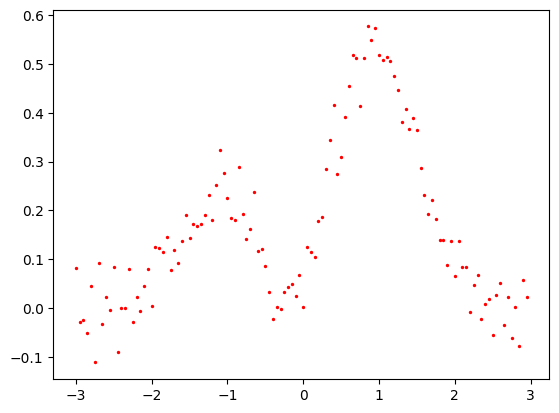

In [15]:
data = np.loadtxt("DSM_assignment1_regression_data.csv")
x = data[:, 0]
y = data[:, 1]

plt.scatter(x, y, s=2, c="red");

**Exercise 9:** use $10$-fold cross-validation to estimate the root-mean-square error (RMSE) of a K-nearest neighbor regression model with uniform weights and with varying number of nearest neighbors taken into account. In other words, use the cell below to make a plot of the CV-estimated RMSE (**including** errorbars signifying one standard deviation) as a function of $K$. Choose the range of $K$ such that the bias-variance tradeoff is clearly visible in the plot.

Finally, use the second cell below (the markdown cell) to explain, in your own words, the optimal choice for the value of $K$ based on your analysis.

You may use existing packages to perform the K-nearest neighbors regression (e.g. sklearn, statsmodels), but the code for cross-validation may not rely on existing packages. However, you may freely copy and use code from the computer classes.


Text(0.5, 1.0, '10-fold CV RMSE K-nearest neighbours')

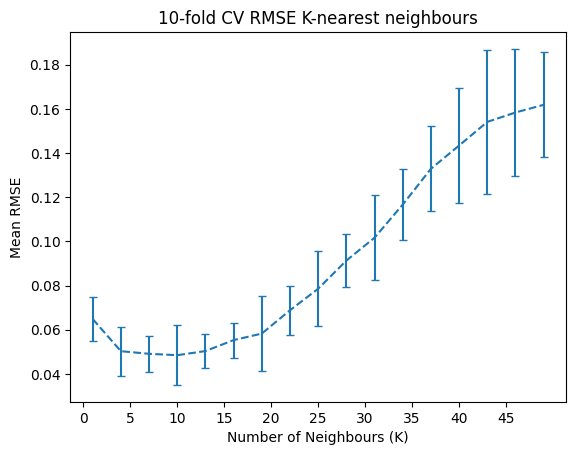

In [16]:
def ten_fold_cv(model: BaseEstimator) -> list[float]:
    # Shuffle the data
    shuffeling = np.random.permutation(len(x))
    shuffled_x = x[shuffeling].reshape(-1, 1)
    shuffled_y = y[shuffeling]

    x_folds = np.split(shuffled_x, 10)
    y_folds = np.split(shuffled_y, 10)

    results = list()

    for i in range(10):
        x_train = np.concat(x_folds[:i] + x_folds[i + 1 :])
        x_test = x_folds[i]
        y_train = np.concat(y_folds[:i] + y_folds[i + 1 :])
        y_test = y_folds[i]
        model.fit(X=x_train, y=y_train)
        y_hat = model.predict(x_test)
        score = root_mean_squared_error(y_test, y_hat)
        results.append(score)

    return results


knn_results = dict()
for k in np.arange(1, 50, 3):
    knn_results[k] = ten_fold_cv(KNeighborsRegressor(n_neighbors=k))

means = [np.mean(r) for r in knn_results.values()]
std_dev = [np.std(r) for r in knn_results.values()]

plt.errorbar(
    x=list(knn_results.keys()), y=means, yerr=std_dev, capsize=3, linestyle="dashed"
)
plt.xlabel("Number of Neighbours (K)")
plt.xticks(np.arange(0, 50, 5))
plt.ylabel("Mean RMSE")
plt.title("10-fold CV RMSE K-nearest neighbours")


#### ANSWER IN PLAIN TEXT:


**Exercise 10:** repeat the previous exercise, but now for kernel regression with a Gaussian kernel. Plot the RMSE as a function of the bandwidth, instead of the number of nearest neighbors taken into account. Again, use the second cell below (the markdown cell) to explain, in your own words, the optimal choice for the value of the bandwidth based on your analysis.

You may use existing packages to perform the kernel regression (e.g. sklearn, statsmodels), but the code for cross-validation may not rely on existing packages. However, you may freely copy and use code from the computer classes.


Text(0.5, 1.0, '10-fold CV RMSE K-nearest neighbours')

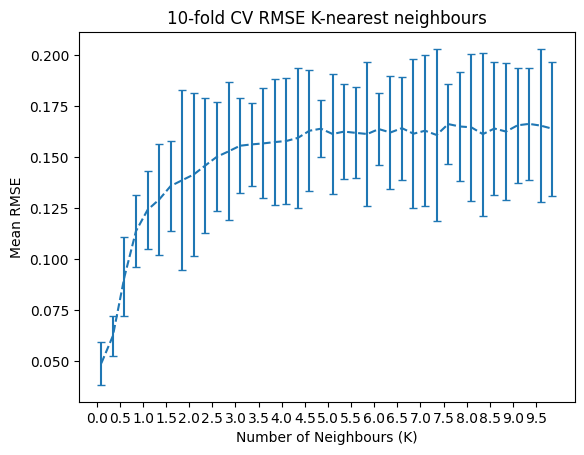

In [17]:
def ten_fold_cv_sm(bandwidth: float) -> list[float]:
    # Shuffle the data
    shuffeling = np.random.permutation(len(x))
    shuffled_x = x[shuffeling].reshape(-1, 1)
    shuffled_y = y[shuffeling]

    x_folds = np.split(shuffled_x, 10)
    y_folds = np.split(shuffled_y, 10)

    results = list()

    for i in range(10):
        x_train = np.concat(x_folds[:i] + x_folds[i + 1 :])
        x_test = x_folds[i]
        y_train = np.concat(y_folds[:i] + y_folds[i + 1 :])
        y_test = y_folds[i]
        model = KernelReg(y_train, x_train, var_type="c", bw=[bandwidth])
        model.fit()
        y_hat = model.fit(x_test)[0]
        score = root_mean_squared_error(y_test, y_hat)
        results.append(score)

    return results


gaussian_results = list()
bw_values = list()
for bw in np.arange(0.1, 10, 0.25):
    gaussian_results.append(ten_fold_cv_sm(bw))
    bw_values.append(bw)

means = [np.mean(r) for r in gaussian_results]
std_dev = [np.std(r) for r in gaussian_results]

plt.errorbar(x=bw_values, y=means, yerr=std_dev, capsize=3, linestyle="dashed")
plt.xlabel("Number of Neighbours (K)")
plt.xticks(np.arange(0, 10, 0.5))
plt.ylabel("Mean RMSE")
plt.title("10-fold CV RMSE K-nearest neighbours")

#### ANSWER IN PLAIN TEXT:


**Exercise 11:** repeat the analysis of the two previous exercises, but now for polynomial regression. Plot the RMSE as a function of the degree of the polynomial, instead of the number of nearest neighbors taken into account or the bandwidth. Again, use the second cell below (the markdown cell) to explain, in your own words, the optimal choice for the value of the degree of the polynomial based on your analysis.

You may use existing packages to perform the polynomial regression (e.g. sklearn, statsmodels), but the code for cross-validation may not rely on existing packages. However, you may freely copy and use code from the computer classes.


Text(0.5, 1.0, '10-fold CV RMSE Polynomial Regression')

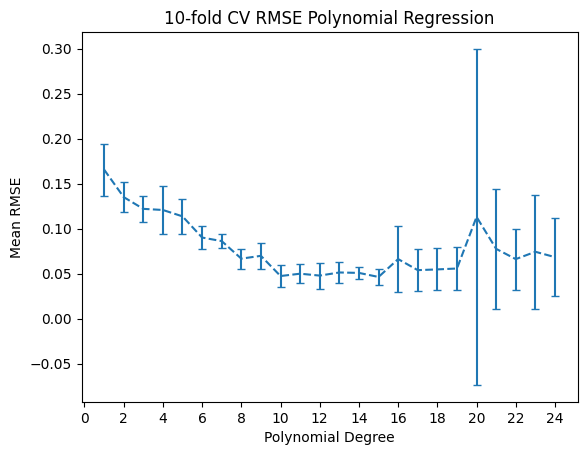

In [18]:
polynomial_results = dict()
for d in np.arange(1, 25, 1):
    pipe = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())
    polynomial_results[d] = ten_fold_cv(pipe)

means = [np.mean(r) for r in polynomial_results.values()]
std_dev = [np.std(r) for r in polynomial_results.values()]

plt.errorbar(
    x=list(polynomial_results.keys()),
    y=means,
    yerr=std_dev,
    capsize=3,
    linestyle="dashed",
)
plt.xlabel("Polynomial Degree")
plt.xticks(np.arange(0, 25, 2))
plt.ylabel("Mean RMSE")
plt.title("10-fold CV RMSE Polynomial Regression")

#### ANSWER IN PLAIN TEXT:


**Exercise 12:** create a single plot that includes the original data and the optimal predictions according to the three methods of regression applied in the previous three exercises. Use a legend to make clear which prediction is associated with which method.


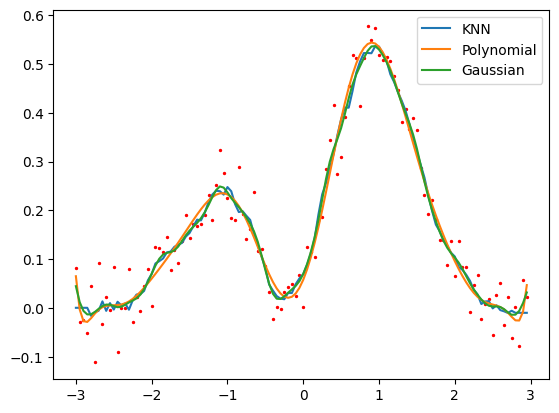

In [19]:
knn = KNeighborsRegressor(n_neighbors=7).fit(x.reshape(-1, 1), y)
pipe = make_pipeline(PolynomialFeatures(degree=14), LinearRegression()).fit(
    x.reshape(-1, 1), y
)
gaussian = KernelReg(y, x, var_type="c", bw=[0.1])
gaussian.fit()

plt.scatter(x, y, s=2, c="red")
plt.plot(x, knn.predict(x.reshape(-1, 1)), label="KNN")
plt.plot(x, pipe.predict(x.reshape(-1, 1)), label="Polynomial")
plt.plot(x, gaussian.fit(x)[0], label="Gaussian")
plt.legend()

**Exercise 13:** the DataFrame `df` that is uploaded in the cell below contains 9 missing values. Use your analysis of the previous exercises to complete the DataFrame by filling in and/or computing the missing values.

Finally, use the markdown cell at the bottom of the notebook to explain (in your own words) whether or not, based on your analysis, any of the models is preferable over the others.


In [20]:
df = pd.read_pickle("DSM_assignment1_dataframe_empty.csv")
df.loc["K-nearest neighbors"] = [
    "K",
    7,
    np.mean(knn_results[7]),
    np.std(knn_results[7]),
]
df.loc["kernel regression"] = [
    "bandwidth",
    0.1,
    np.mean(gaussian_results[0]),
    np.std(gaussian_results[0]),
]
df.loc["polynomial regression"] = [
    "degree of polynomial",
    15,
    np.mean(polynomial_results[15]),
    np.std(polynomial_results[15]),
]
df

,type of hyperparameter,optimal value of hyperparameter,optimal RMSE (10-fold CV estimate),standard deviation of RMSE estimate
K-nearest neighbors,K,7.0,0.049102,0.008181
kernel regression,bandwidth,0.1,0.048876,0.010628
polynomial regression,degree of polynomial,15.0,0.046390,0.009089


#### ANSWER IN PLAIN TEXT:
